In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    # eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    # aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], feed_dict)
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 aloss:0.7017 eloss:2.1762 aloss2:1.6207 exploreP:0.9979
Episode:1 meanR:17.5000 R:14.0000 rate:0.0280 aloss:0.7034 eloss:2.1500 aloss2:1.6345 exploreP:0.9965
Episode:2 meanR:16.6667 R:15.0000 rate:0.0300 aloss:0.6961 eloss:2.1259 aloss2:1.6642 exploreP:0.9951
Episode:3 meanR:15.5000 R:12.0000 rate:0.0240 aloss:0.6958 eloss:2.1245 aloss2:1.6656 exploreP:0.9939
Episode:4 meanR:17.2000 R:24.0000 rate:0.0480 aloss:0.6973 eloss:2.0966 aloss2:1.6874 exploreP:0.9915
Episode:5 meanR:18.6667 R:26.0000 rate:0.0520 aloss:0.6916 eloss:2.0919 aloss2:1.6998 exploreP:0.9890
Episode:6 meanR:17.5714 R:11.0000 rate:0.0220 aloss:0.6997 eloss:2.0913 aloss2:1.6925 exploreP:0.9879
Episode:7 meanR:19.3750 R:32.0000 rate:0.0640 aloss:0.6894 eloss:2.1182 aloss2:1.6577 exploreP:0.9848
Episode:8 meanR:18.6667 R:13.0000 rate:0.0260 aloss:0.6898 eloss:2.0629 aloss2:1.6814 exploreP:0.9835
Episode:9 meanR:25.4000 R:86.0000 rate:0.1720 aloss:0.6854 eloss:2.0101 aloss2:1.7

Episode:80 meanR:29.4815 R:47.0000 rate:0.0940 aloss:0.6802 eloss:0.3489 aloss2:4.7580 exploreP:0.7897
Episode:81 meanR:29.2927 R:14.0000 rate:0.0280 aloss:0.6729 eloss:0.0375 aloss2:4.9296 exploreP:0.7886
Episode:82 meanR:29.5783 R:53.0000 rate:0.1060 aloss:0.7018 eloss:0.1051 aloss2:5.0242 exploreP:0.7845
Episode:83 meanR:29.4881 R:22.0000 rate:0.0440 aloss:0.6691 eloss:0.0099 aloss2:4.8141 exploreP:0.7828
Episode:84 meanR:30.1882 R:89.0000 rate:0.1780 aloss:0.6721 eloss:-0.3327 aloss2:5.2720 exploreP:0.7759
Episode:85 meanR:31.3953 R:134.0000 rate:0.2680 aloss:0.6822 eloss:-0.6335 aloss2:5.5798 exploreP:0.7657
Episode:86 meanR:31.4368 R:35.0000 rate:0.0700 aloss:0.6730 eloss:-1.0523 aloss2:6.1067 exploreP:0.7631
Episode:87 meanR:31.6364 R:49.0000 rate:0.0980 aloss:0.6815 eloss:-1.0217 aloss2:6.0155 exploreP:0.7594
Episode:88 meanR:31.5169 R:21.0000 rate:0.0420 aloss:0.6655 eloss:-1.1478 aloss2:6.2475 exploreP:0.7579
Episode:89 meanR:31.4667 R:27.0000 rate:0.0540 aloss:0.6789 eloss:-

Episode:158 meanR:63.2700 R:192.0000 rate:0.3840 aloss:0.6721 eloss:-6.1386 aloss2:27.4742 exploreP:0.4598
Episode:159 meanR:63.3700 R:35.0000 rate:0.0700 aloss:0.6717 eloss:-6.6356 aloss2:28.0370 exploreP:0.4582
Episode:160 meanR:65.4100 R:233.0000 rate:0.4660 aloss:0.6717 eloss:-6.3697 aloss2:28.2149 exploreP:0.4479
Episode:161 meanR:66.4500 R:123.0000 rate:0.2460 aloss:0.6753 eloss:-6.8092 aloss2:29.2513 exploreP:0.4425
Episode:162 meanR:68.1300 R:196.0000 rate:0.3920 aloss:0.6744 eloss:-6.2469 aloss2:29.8749 exploreP:0.4341
Episode:163 meanR:69.1600 R:142.0000 rate:0.2840 aloss:0.6737 eloss:-7.1718 aloss2:31.1655 exploreP:0.4281
Episode:164 meanR:71.7000 R:290.0000 rate:0.5800 aloss:0.6730 eloss:-7.1846 aloss2:32.2255 exploreP:0.4162
Episode:165 meanR:74.1900 R:269.0000 rate:0.5380 aloss:0.6744 eloss:-7.3587 aloss2:33.3543 exploreP:0.4054
Episode:166 meanR:76.2900 R:225.0000 rate:0.4500 aloss:0.6780 eloss:-7.3206 aloss2:34.9707 exploreP:0.3966
Episode:167 meanR:76.4700 R:65.0000 ra

Episode:235 meanR:115.0700 R:11.0000 rate:0.0220 aloss:0.6818 eloss:-8.8191 aloss2:44.8376 exploreP:0.1927
Episode:236 meanR:114.1200 R:11.0000 rate:0.0220 aloss:0.6773 eloss:-8.3535 aloss2:45.9251 exploreP:0.1925
Episode:237 meanR:114.6600 R:95.0000 rate:0.1900 aloss:0.6812 eloss:-8.2031 aloss2:45.1388 exploreP:0.1908
Episode:238 meanR:114.1000 R:117.0000 rate:0.2340 aloss:0.6862 eloss:-7.8429 aloss2:45.2699 exploreP:0.1887
Episode:239 meanR:114.5800 R:112.0000 rate:0.2240 aloss:0.6882 eloss:-8.7379 aloss2:45.2518 exploreP:0.1867
Episode:240 meanR:112.7600 R:32.0000 rate:0.0640 aloss:0.6880 eloss:-9.4501 aloss2:45.3711 exploreP:0.1861
Episode:241 meanR:111.8700 R:12.0000 rate:0.0240 aloss:0.6827 eloss:-8.7277 aloss2:45.1491 exploreP:0.1859
Episode:242 meanR:113.0500 R:142.0000 rate:0.2840 aloss:0.6856 eloss:-7.0799 aloss2:45.5660 exploreP:0.1834
Episode:243 meanR:112.5500 R:95.0000 rate:0.1900 aloss:0.6837 eloss:-8.0735 aloss2:45.9012 exploreP:0.1818
Episode:244 meanR:111.7600 R:100.0

Episode:312 meanR:91.1100 R:68.0000 rate:0.1360 aloss:0.6925 eloss:-6.4470 aloss2:45.4402 exploreP:0.0982
Episode:313 meanR:90.4300 R:74.0000 rate:0.1480 aloss:0.6963 eloss:-6.0151 aloss2:46.0554 exploreP:0.0975
Episode:314 meanR:89.0800 R:72.0000 rate:0.1440 aloss:0.6946 eloss:-8.4055 aloss2:46.3761 exploreP:0.0969
Episode:315 meanR:90.1000 R:159.0000 rate:0.3180 aloss:0.6910 eloss:-8.2733 aloss2:46.3050 exploreP:0.0955
Episode:316 meanR:89.3400 R:52.0000 rate:0.1040 aloss:0.6974 eloss:-7.8649 aloss2:45.9951 exploreP:0.0951
Episode:317 meanR:89.6100 R:140.0000 rate:0.2800 aloss:0.6876 eloss:-7.5360 aloss2:46.2265 exploreP:0.0939
Episode:318 meanR:88.2800 R:33.0000 rate:0.0660 aloss:0.6878 eloss:-4.8374 aloss2:47.3852 exploreP:0.0936
Episode:319 meanR:89.5400 R:160.0000 rate:0.3200 aloss:0.6950 eloss:-6.6059 aloss2:45.9722 exploreP:0.0923
Episode:320 meanR:89.5200 R:60.0000 rate:0.1200 aloss:0.6968 eloss:-6.7033 aloss2:46.3679 exploreP:0.0918
Episode:321 meanR:90.0300 R:81.0000 rate:0.

Episode:390 meanR:95.3000 R:108.0000 rate:0.2160 aloss:0.6771 eloss:-5.7672 aloss2:48.9395 exploreP:0.0503
Episode:391 meanR:95.9700 R:96.0000 rate:0.1920 aloss:0.6888 eloss:-9.1231 aloss2:48.8272 exploreP:0.0499
Episode:392 meanR:96.5000 R:78.0000 rate:0.1560 aloss:0.6853 eloss:-8.7570 aloss2:49.3502 exploreP:0.0496
Episode:393 meanR:94.9300 R:82.0000 rate:0.1640 aloss:0.6919 eloss:-7.5443 aloss2:49.2792 exploreP:0.0493
Episode:394 meanR:93.1200 R:67.0000 rate:0.1340 aloss:0.6852 eloss:-4.3541 aloss2:48.9615 exploreP:0.0490
Episode:395 meanR:92.9400 R:83.0000 rate:0.1660 aloss:0.6909 eloss:-7.7112 aloss2:49.3031 exploreP:0.0487
Episode:396 meanR:93.0000 R:90.0000 rate:0.1800 aloss:0.6812 eloss:-6.9060 aloss2:48.7323 exploreP:0.0484
Episode:397 meanR:93.7900 R:90.0000 rate:0.1800 aloss:0.6904 eloss:-7.7700 aloss2:48.4792 exploreP:0.0480
Episode:398 meanR:94.7500 R:106.0000 rate:0.2120 aloss:0.6844 eloss:-7.7257 aloss2:48.5092 exploreP:0.0476
Episode:399 meanR:94.5700 R:69.0000 rate:0.1

Episode:467 meanR:100.1700 R:72.0000 rate:0.1440 aloss:0.6807 eloss:-6.4153 aloss2:48.9407 exploreP:0.0288
Episode:468 meanR:100.2400 R:120.0000 rate:0.2400 aloss:0.6943 eloss:-8.9355 aloss2:49.0796 exploreP:0.0285
Episode:469 meanR:100.4400 R:81.0000 rate:0.1620 aloss:0.6895 eloss:-8.0047 aloss2:49.4253 exploreP:0.0284
Episode:470 meanR:99.2900 R:77.0000 rate:0.1540 aloss:0.6854 eloss:-4.9261 aloss2:49.3407 exploreP:0.0283
Episode:471 meanR:98.9700 R:120.0000 rate:0.2400 aloss:0.6885 eloss:-9.0657 aloss2:49.1369 exploreP:0.0280
Episode:472 meanR:98.9700 R:81.0000 rate:0.1620 aloss:0.6858 eloss:-7.8216 aloss2:49.4368 exploreP:0.0279
Episode:473 meanR:99.2000 R:102.0000 rate:0.2040 aloss:0.6829 eloss:-8.5031 aloss2:49.8350 exploreP:0.0277
Episode:474 meanR:99.3500 R:111.0000 rate:0.2220 aloss:0.6853 eloss:-8.4398 aloss2:49.1565 exploreP:0.0275
Episode:475 meanR:99.7700 R:108.0000 rate:0.2160 aloss:0.6800 eloss:-9.0381 aloss2:50.1423 exploreP:0.0273
Episode:476 meanR:99.7600 R:91.0000 ra

Episode:544 meanR:102.1300 R:76.0000 rate:0.1520 aloss:0.6677 eloss:-9.0274 aloss2:50.1960 exploreP:0.0184
Episode:545 meanR:102.0300 R:66.0000 rate:0.1320 aloss:0.6801 eloss:-6.9323 aloss2:50.7067 exploreP:0.0183
Episode:546 meanR:102.0300 R:77.0000 rate:0.1540 aloss:0.6848 eloss:-8.4834 aloss2:50.9842 exploreP:0.0183
Episode:547 meanR:102.6800 R:195.0000 rate:0.3900 aloss:0.6716 eloss:-7.6749 aloss2:50.6820 exploreP:0.0181
Episode:548 meanR:103.2300 R:114.0000 rate:0.2280 aloss:0.6786 eloss:-8.7330 aloss2:50.3517 exploreP:0.0180
Episode:549 meanR:103.0500 R:94.0000 rate:0.1880 aloss:0.6760 eloss:-8.7897 aloss2:51.2824 exploreP:0.0179
Episode:550 meanR:102.9600 R:88.0000 rate:0.1760 aloss:0.6718 eloss:-8.2929 aloss2:50.9680 exploreP:0.0179
Episode:551 meanR:103.0400 R:75.0000 rate:0.1500 aloss:0.6788 eloss:-8.6734 aloss2:51.6948 exploreP:0.0178
Episode:552 meanR:102.7900 R:80.0000 rate:0.1600 aloss:0.6690 eloss:-8.8082 aloss2:51.4379 exploreP:0.0177
Episode:553 meanR:102.4500 R:72.000

Episode:621 meanR:102.3500 R:113.0000 rate:0.2260 aloss:0.6794 eloss:-9.0350 aloss2:52.7712 exploreP:0.0140
Episode:622 meanR:101.7700 R:75.0000 rate:0.1500 aloss:0.6762 eloss:-8.2523 aloss2:52.5659 exploreP:0.0139
Episode:623 meanR:101.4200 R:69.0000 rate:0.1380 aloss:0.6962 eloss:-7.5270 aloss2:52.5810 exploreP:0.0139
Episode:624 meanR:101.0000 R:51.0000 rate:0.1020 aloss:0.6672 eloss:-9.6149 aloss2:52.4733 exploreP:0.0139
Episode:625 meanR:100.9300 R:78.0000 rate:0.1560 aloss:0.6881 eloss:-7.5399 aloss2:52.3664 exploreP:0.0139
Episode:626 meanR:100.6400 R:49.0000 rate:0.0980 aloss:0.6603 eloss:-5.2772 aloss2:52.0973 exploreP:0.0138
Episode:627 meanR:100.6100 R:79.0000 rate:0.1580 aloss:0.6825 eloss:-9.3183 aloss2:52.5317 exploreP:0.0138
Episode:628 meanR:99.8500 R:55.0000 rate:0.1100 aloss:0.6783 eloss:-8.3995 aloss2:52.0710 exploreP:0.0138
Episode:629 meanR:99.7500 R:46.0000 rate:0.0920 aloss:0.6667 eloss:-9.5367 aloss2:52.5854 exploreP:0.0138
Episode:630 meanR:99.0700 R:90.0000 ra

Episode:699 meanR:88.0300 R:47.0000 rate:0.0940 aloss:0.6547 eloss:-9.1742 aloss2:55.2064 exploreP:0.0120
Episode:700 meanR:88.0400 R:70.0000 rate:0.1400 aloss:0.6596 eloss:-4.0431 aloss2:54.6542 exploreP:0.0120
Episode:701 meanR:88.1400 R:86.0000 rate:0.1720 aloss:0.6543 eloss:-9.8579 aloss2:54.1108 exploreP:0.0120
Episode:702 meanR:88.0800 R:69.0000 rate:0.1380 aloss:0.6681 eloss:-10.3339 aloss2:54.7834 exploreP:0.0120
Episode:703 meanR:88.8500 R:126.0000 rate:0.2520 aloss:0.6584 eloss:-9.0533 aloss2:54.9652 exploreP:0.0119
Episode:704 meanR:88.6800 R:104.0000 rate:0.2080 aloss:0.6584 eloss:-9.7527 aloss2:54.8043 exploreP:0.0119
Episode:705 meanR:89.1900 R:128.0000 rate:0.2560 aloss:0.6513 eloss:-8.7613 aloss2:55.2843 exploreP:0.0119
Episode:706 meanR:88.7300 R:73.0000 rate:0.1460 aloss:0.6622 eloss:-9.0738 aloss2:54.9340 exploreP:0.0119
Episode:707 meanR:88.6700 R:50.0000 rate:0.1000 aloss:0.6463 eloss:-9.8235 aloss2:55.5583 exploreP:0.0119
Episode:708 meanR:87.9500 R:45.0000 rate:0

Episode:777 meanR:97.8800 R:66.0000 rate:0.1320 aloss:0.6407 eloss:-8.9585 aloss2:56.4367 exploreP:0.0109
Episode:778 meanR:98.1900 R:94.0000 rate:0.1880 aloss:0.6298 eloss:-9.0473 aloss2:56.8063 exploreP:0.0109
Episode:779 meanR:98.0100 R:51.0000 rate:0.1020 aloss:0.6372 eloss:-9.8295 aloss2:57.2784 exploreP:0.0109
Episode:780 meanR:98.3800 R:86.0000 rate:0.1720 aloss:0.6510 eloss:-7.3196 aloss2:56.8698 exploreP:0.0109
Episode:781 meanR:98.1800 R:47.0000 rate:0.0940 aloss:0.6530 eloss:-0.3159 aloss2:56.3387 exploreP:0.0109
Episode:782 meanR:97.4900 R:53.0000 rate:0.1060 aloss:0.6689 eloss:-9.5469 aloss2:56.4750 exploreP:0.0109
Episode:783 meanR:97.4400 R:64.0000 rate:0.1280 aloss:0.6451 eloss:-8.4865 aloss2:56.0449 exploreP:0.0109
Episode:784 meanR:97.4800 R:61.0000 rate:0.1220 aloss:0.6355 eloss:-5.1918 aloss2:55.9628 exploreP:0.0109
Episode:785 meanR:98.4600 R:153.0000 rate:0.3060 aloss:0.6371 eloss:-6.8916 aloss2:55.5836 exploreP:0.0109
Episode:786 meanR:99.2200 R:133.0000 rate:0.2

Episode:854 meanR:110.2800 R:90.0000 rate:0.1800 aloss:0.5865 eloss:-8.5640 aloss2:57.7682 exploreP:0.0104
Episode:855 meanR:110.1900 R:63.0000 rate:0.1260 aloss:0.5847 eloss:-9.5366 aloss2:58.6849 exploreP:0.0104
Episode:856 meanR:110.2300 R:65.0000 rate:0.1300 aloss:0.5797 eloss:-9.1011 aloss2:58.8351 exploreP:0.0104
Episode:857 meanR:110.5100 R:79.0000 rate:0.1580 aloss:0.5739 eloss:-5.0142 aloss2:58.3951 exploreP:0.0104
Episode:858 meanR:110.4100 R:55.0000 rate:0.1100 aloss:0.5842 eloss:-6.7888 aloss2:58.0810 exploreP:0.0104
Episode:859 meanR:110.2700 R:47.0000 rate:0.0940 aloss:0.5817 eloss:-8.7809 aloss2:57.7707 exploreP:0.0104
Episode:860 meanR:110.2700 R:63.0000 rate:0.1260 aloss:0.5779 eloss:-8.7530 aloss2:58.1693 exploreP:0.0104
Episode:861 meanR:110.3200 R:49.0000 rate:0.0980 aloss:0.5762 eloss:-9.4099 aloss2:58.7595 exploreP:0.0104
Episode:862 meanR:110.6300 R:84.0000 rate:0.1680 aloss:0.5825 eloss:-4.5376 aloss2:58.5501 exploreP:0.0104
Episode:863 meanR:110.0000 R:105.0000

Episode:931 meanR:118.5200 R:72.0000 rate:0.1440 aloss:0.5600 eloss:-9.0792 aloss2:61.1156 exploreP:0.0102
Episode:932 meanR:118.4600 R:55.0000 rate:0.1100 aloss:0.5447 eloss:-9.2829 aloss2:60.5736 exploreP:0.0102
Episode:933 meanR:116.7500 R:65.0000 rate:0.1300 aloss:0.5370 eloss:-7.8369 aloss2:60.9579 exploreP:0.0102
Episode:934 meanR:116.6300 R:68.0000 rate:0.1360 aloss:0.5508 eloss:-5.6059 aloss2:60.4570 exploreP:0.0102
Episode:935 meanR:115.5400 R:54.0000 rate:0.1080 aloss:0.5329 eloss:-10.2400 aloss2:61.0572 exploreP:0.0102
Episode:936 meanR:116.6100 R:191.0000 rate:0.3820 aloss:0.5140 eloss:-6.9677 aloss2:61.4465 exploreP:0.0102
Episode:937 meanR:116.6500 R:78.0000 rate:0.1560 aloss:0.5186 eloss:-5.6829 aloss2:61.0382 exploreP:0.0101
Episode:938 meanR:116.1500 R:42.0000 rate:0.0840 aloss:0.5729 eloss:-7.1406 aloss2:59.8525 exploreP:0.0101
Episode:939 meanR:116.7100 R:131.0000 rate:0.2620 aloss:0.5484 eloss:-7.2974 aloss2:60.5246 exploreP:0.0101
Episode:940 meanR:114.7500 R:294.0

Episode:1008 meanR:110.8200 R:59.0000 rate:0.1180 aloss:0.5018 eloss:-9.5451 aloss2:60.7846 exploreP:0.0101
Episode:1009 meanR:108.4100 R:62.0000 rate:0.1240 aloss:0.5206 eloss:-3.9029 aloss2:60.8530 exploreP:0.0101
Episode:1010 meanR:107.1900 R:88.0000 rate:0.1760 aloss:0.5151 eloss:-7.3613 aloss2:61.1409 exploreP:0.0101
Episode:1011 meanR:107.1900 R:51.0000 rate:0.1020 aloss:0.4958 eloss:-10.1079 aloss2:60.5174 exploreP:0.0101
Episode:1012 meanR:105.6400 R:82.0000 rate:0.1640 aloss:0.5094 eloss:-9.0271 aloss2:61.1787 exploreP:0.0101
Episode:1013 meanR:102.2700 R:133.0000 rate:0.2660 aloss:0.4927 eloss:-9.1876 aloss2:60.9336 exploreP:0.0101
Episode:1014 meanR:103.4900 R:181.0000 rate:0.3620 aloss:0.4961 eloss:-7.6126 aloss2:61.2569 exploreP:0.0101
Episode:1015 meanR:103.3700 R:39.0000 rate:0.0780 aloss:0.5109 eloss:-8.4058 aloss2:61.8606 exploreP:0.0101
Episode:1016 meanR:103.3600 R:74.0000 rate:0.1480 aloss:0.4963 eloss:-5.8379 aloss2:60.8709 exploreP:0.0101
Episode:1017 meanR:101.88

Episode:1085 meanR:89.9100 R:55.0000 rate:0.1100 aloss:0.4256 eloss:-9.1477 aloss2:63.8783 exploreP:0.0100
Episode:1086 meanR:89.9500 R:69.0000 rate:0.1380 aloss:0.4609 eloss:-7.1451 aloss2:63.1556 exploreP:0.0100
Episode:1087 meanR:88.7600 R:57.0000 rate:0.1140 aloss:0.4594 eloss:-7.2055 aloss2:63.7996 exploreP:0.0100
Episode:1088 meanR:90.3200 R:206.0000 rate:0.4120 aloss:0.4630 eloss:-6.4157 aloss2:63.5106 exploreP:0.0100
Episode:1089 meanR:89.6600 R:53.0000 rate:0.1060 aloss:0.4956 eloss:-9.3843 aloss2:62.9370 exploreP:0.0100
Episode:1090 meanR:89.7200 R:67.0000 rate:0.1340 aloss:0.4431 eloss:-6.7201 aloss2:64.2486 exploreP:0.0100
Episode:1091 meanR:90.1700 R:95.0000 rate:0.1900 aloss:0.4460 eloss:8.2960 aloss2:63.0640 exploreP:0.0100
Episode:1092 meanR:89.4300 R:45.0000 rate:0.0900 aloss:0.4263 eloss:-9.6870 aloss2:63.3668 exploreP:0.0100
Episode:1093 meanR:88.1500 R:49.0000 rate:0.0980 aloss:0.4687 eloss:-8.6881 aloss2:63.6625 exploreP:0.0100
Episode:1094 meanR:87.8800 R:40.0000 

Episode:1162 meanR:87.4600 R:49.0000 rate:0.0980 aloss:0.4107 eloss:-8.1569 aloss2:65.0996 exploreP:0.0100
Episode:1163 meanR:87.1600 R:49.0000 rate:0.0980 aloss:0.4222 eloss:-7.4266 aloss2:64.9560 exploreP:0.0100
Episode:1164 meanR:87.4200 R:79.0000 rate:0.1580 aloss:0.4043 eloss:-3.9509 aloss2:64.7782 exploreP:0.0100
Episode:1165 meanR:87.2200 R:49.0000 rate:0.0980 aloss:0.4246 eloss:-8.9080 aloss2:64.5363 exploreP:0.0100
Episode:1166 meanR:87.5200 R:87.0000 rate:0.1740 aloss:0.4699 eloss:1.9109 aloss2:64.0292 exploreP:0.0100
Episode:1167 meanR:88.2000 R:119.0000 rate:0.2380 aloss:0.4140 eloss:-8.7942 aloss2:64.5404 exploreP:0.0100
Episode:1168 meanR:88.0600 R:45.0000 rate:0.0900 aloss:0.4138 eloss:-9.5563 aloss2:65.0855 exploreP:0.0100
Episode:1169 meanR:87.8800 R:47.0000 rate:0.0940 aloss:0.3708 eloss:-10.4949 aloss2:64.8477 exploreP:0.0100
Episode:1170 meanR:88.4500 R:106.0000 rate:0.2120 aloss:0.4543 eloss:-4.5434 aloss2:64.8151 exploreP:0.0100
Episode:1171 meanR:88.8200 R:103.00

Episode:1239 meanR:85.6600 R:237.0000 rate:0.4740 aloss:0.4054 eloss:-8.7441 aloss2:65.2983 exploreP:0.0100
Episode:1240 meanR:85.9000 R:73.0000 rate:0.1460 aloss:0.3782 eloss:-9.3444 aloss2:65.7310 exploreP:0.0100
Episode:1241 meanR:84.4800 R:59.0000 rate:0.1180 aloss:0.3931 eloss:-10.3597 aloss2:65.5554 exploreP:0.0100
Episode:1242 meanR:84.9300 R:145.0000 rate:0.2900 aloss:0.4269 eloss:-3.4757 aloss2:65.2167 exploreP:0.0100
Episode:1243 meanR:85.0400 R:61.0000 rate:0.1220 aloss:0.3818 eloss:-10.0324 aloss2:65.6208 exploreP:0.0100
Episode:1244 meanR:85.2200 R:81.0000 rate:0.1620 aloss:0.3486 eloss:-0.2749 aloss2:65.4662 exploreP:0.0100
Episode:1245 meanR:83.4900 R:56.0000 rate:0.1120 aloss:0.3934 eloss:-10.4878 aloss2:65.4220 exploreP:0.0100
Episode:1246 meanR:82.6000 R:48.0000 rate:0.0960 aloss:0.4399 eloss:-4.7024 aloss2:64.8983 exploreP:0.0100
Episode:1247 meanR:81.7800 R:37.0000 rate:0.0740 aloss:0.4127 eloss:-3.8779 aloss2:65.0195 exploreP:0.0100
Episode:1248 meanR:81.8000 R:61.

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

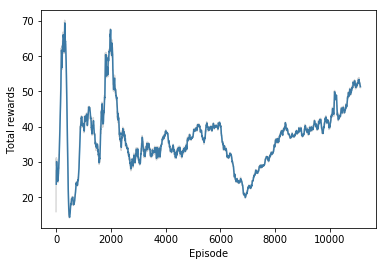

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

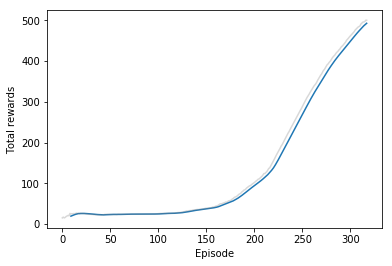

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

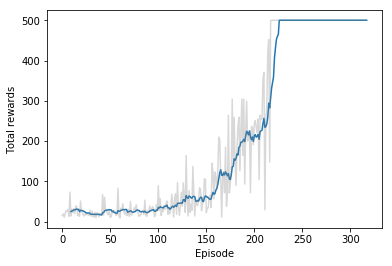

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

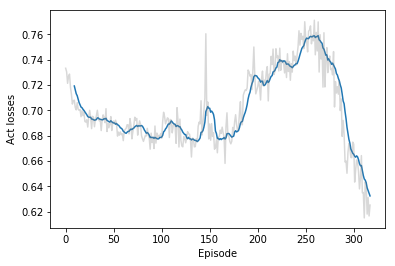

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

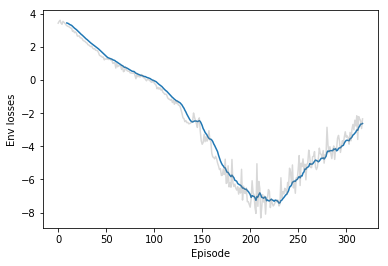

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

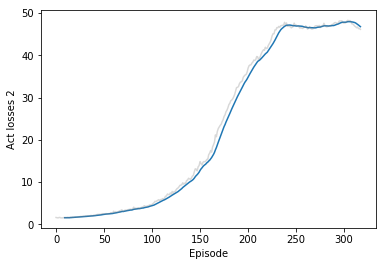

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
